In [3]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../input"))

['train_values.csv', 'train_labels.csv', 'test_values.csv', 'submission_exmpl.csv']


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [4]:
train_values = pd.read_csv("../input/train_values.csv")
train_labels = pd.read_csv("../input/train_labels.csv")
test_values = pd.read_csv("../input/test_values.csv")

train_values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


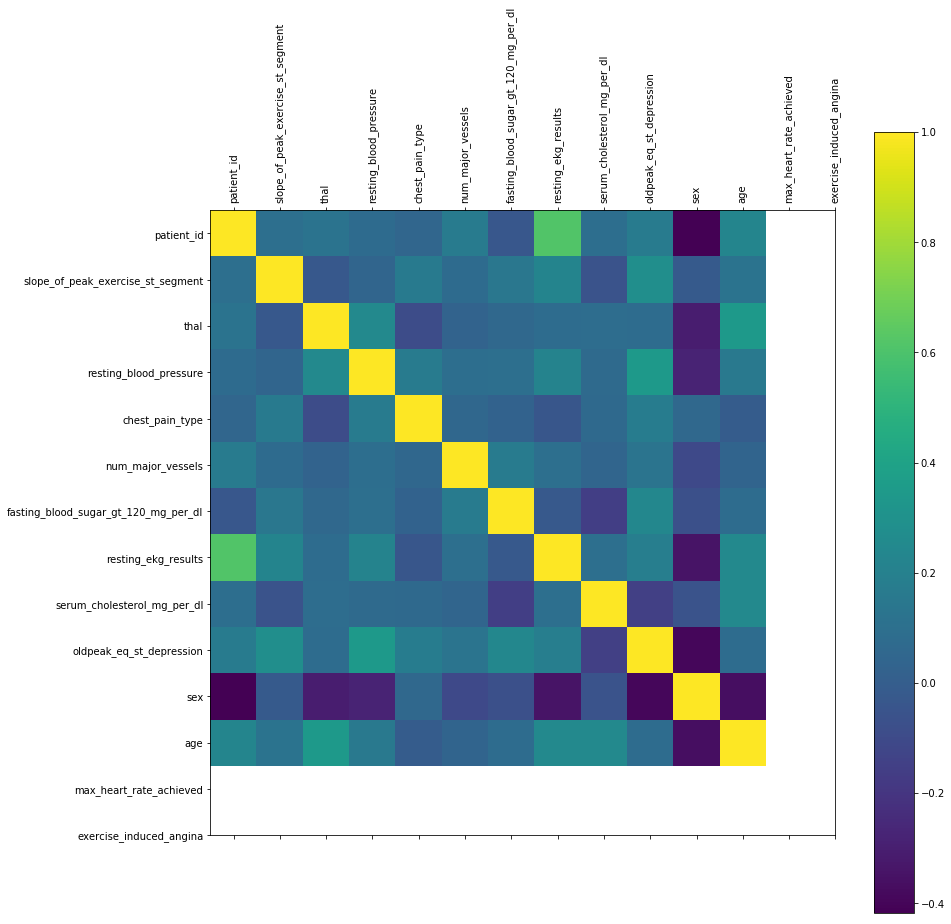

In [6]:
rcParams['figure.figsize'] = 20, 14
plt.matshow(train_values.corr())
plt.yticks(np.arange(train_values.shape[1]), train_values.columns)
plt.xticks(np.arange(train_values.shape[1]), train_values.columns, rotation=90)
plt.colorbar()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc02aa98630>,
      dtype=object)

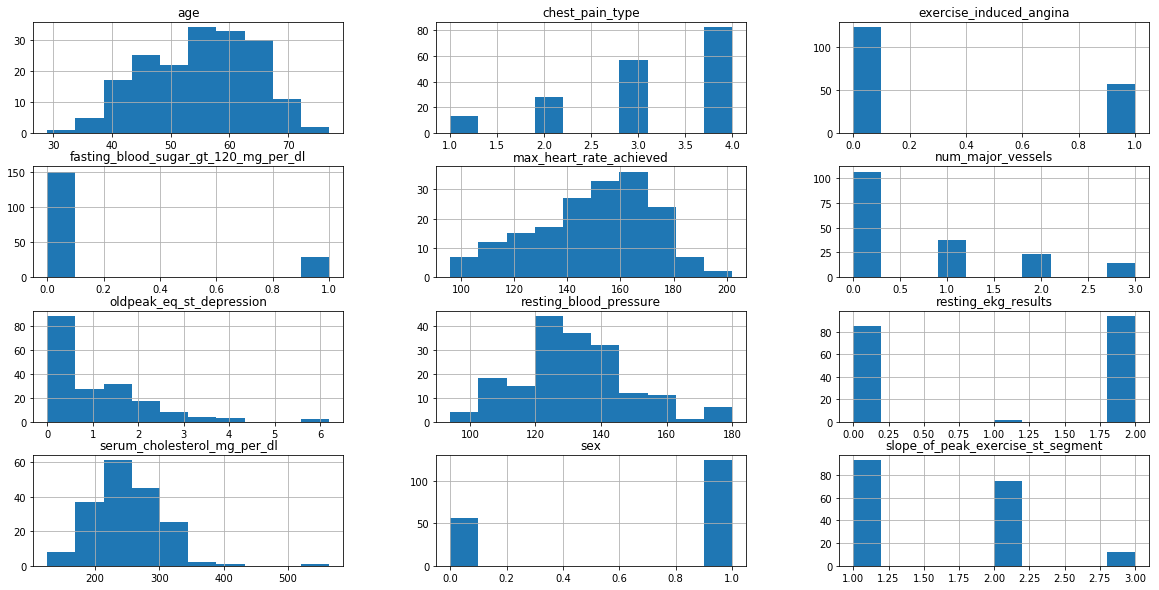

In [7]:
rcParams['figure.figsize'] = 20,10
train_values.hist()

Text(0.5,1,'Count of each Target Class')

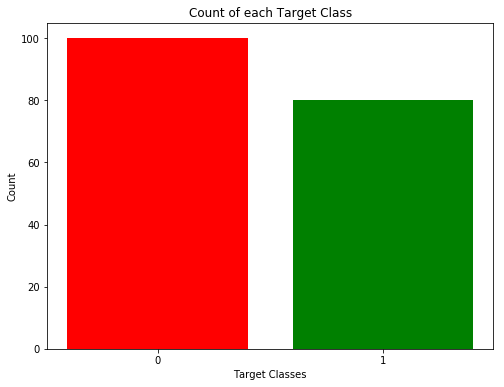

In [8]:
rcParams['figure.figsize'] = 8,6
plt.bar(train_labels['present_heart_disease'].unique(), train_labels['present_heart_disease'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

In [9]:
df = pd.concat([train_values, test_values])

In [10]:
df = pd.get_dummies(df, columns = ['slope_of_peak_exercise_st_segment', 'thal', 'chest_pain_type', 'num_major_vessels', 'fasting_blood_sugar_gt_120_mg_per_dl', 
                                             'resting_ekg_results', 'sex',  'exercise_induced_angina'])

In [11]:
standardScaler = StandardScaler()
columns_to_scale = ['resting_blood_pressure', 'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age', 'max_heart_rate_achieved']
df[columns_to_scale] = standardScaler.fit_transform(df[columns_to_scale])

In [12]:
df.head()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,num_major_vessels_0,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,fasting_blood_sugar_gt_120_mg_per_dl_0,fasting_blood_sugar_gt_120_mg_per_dl_1,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2,sex_0,sex_1,exercise_induced_angina_0,exercise_induced_angina_1
0,0z64un,-0.187590,1.130844,-0.918565,-1.037521,0.878883,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0
1,ryoo3j,-1.197209,-0.691199,0.481153,-0.047660,0.359914,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0
2,yt1s1x,-0.355860,1.053310,-0.918565,2.481986,0.532904,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1
3,l2xjde,1.158569,-0.516748,-0.918565,-1.587444,1.354605,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,1,0
4,oyt4ek,2.616909,0.394274,2.755695,0.502263,-0.202302,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0


In [16]:
train_vals, test_vals = df[:180], df[180:]
train_vals.shape, test_vals.shape

((180, 29), (90, 29))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_vals.drop(['patient_id'], axis = 1), train_labels.drop(['patient_id'], axis = 1), test_size = 0.2, random_state = 2019)

In [19]:
gbm = XGBRegressor(
learning_rate = 0.01,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=0.9,
 subsample=0.8,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

In [20]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time gbm.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 13.5 s, sys: 96 ms, total: 13.6 s
Wall time: 3.42 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.9, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

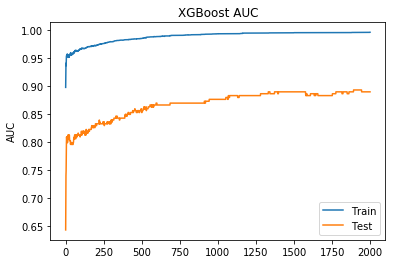

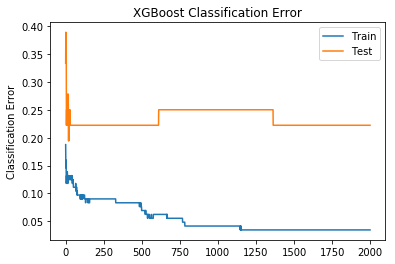

In [23]:
results = gbm.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [24]:
gbm.fit(train_vals.drop(['patient_id'], axis = 1), train_labels.drop(['patient_id'], axis = 1))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.9, importance_type='gain',
       learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
       nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [27]:
def zeroone(pred):
    pred = np.absolute(pred)
    pred[pred > 1] = 1
    return pred

In [28]:
def threshold(pred, th):
    _pred = pred.copy()
    _pred[pred > th] = 1
    _pred[pred <= th] = 0
    return _pred

In [29]:
for i in range(0, 110):
    print(i, accuracy_score(y_test, threshold(pred, i/100)))

ValueError: Found input variables with inconsistent numbers of samples: [36, 90]

In [30]:
pred = gbm.predict(test_vals.drop(['patient_id'], axis = 1))

In [32]:
pred.shape, pred

((90,), array([0.701684  , 0.0571703 , 0.98737437, 0.18661727, 0.98651147,
        0.00976987, 0.04419154, 0.8657705 , 0.556077  , 0.0967245 ,
        0.08596446, 0.4659371 , 0.1264272 , 0.96970975, 0.12710351,
        0.01571402, 0.01452459, 0.0812158 , 0.944044  , 0.00774905,
        0.99234444, 0.01597755, 0.05694029, 0.04536506, 0.7538706 ,
        0.9776593 , 0.4126168 , 0.03709897, 0.46335778, 0.01253651,
        0.97059464, 0.27981025, 0.9050839 , 0.16472016, 0.5833536 ,
        0.03334106, 0.19531213, 0.05850377, 0.41090727, 0.17402248,
        0.97884136, 0.0207039 , 0.98469007, 0.0428604 , 0.98471284,
        0.0262778 , 0.02101396, 0.12322605, 0.37099713, 0.8662462 ,
        0.70602906, 0.00751938, 0.981833  , 0.18131079, 0.24070545,
        0.01218624, 0.8649551 , 0.08644173, 0.0271252 , 0.6987913 ,
        0.01718509, 0.98052806, 0.26591745, 0.95127636, 0.15648292,
        0.96365076, 0.9194016 , 0.8439578 , 0.95484227, 0.6824252 ,
        0.02604868, 0.98183984, 0.9909136

In [33]:
test_vals['present_heart_disease'] = pred

In [34]:
test_vals.tail()

,patient_id,resting_blood_pressure,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,slope_of_peak_exercise_st_segment_1,slope_of_peak_exercise_st_segment_2,slope_of_peak_exercise_st_segment_3,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,num_major_vessels_0,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,fasting_blood_sugar_gt_120_mg_per_dl_0,fasting_blood_sugar_gt_120_mg_per_dl_1,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2,sex_0,sex_1,exercise_induced_angina_0,exercise_induced_angina_1,present_heart_disease
85,bwoyg6,-0.636310,1.751114,-0.918565,0.392278,0.965378,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0.099294
86,j8i3ve,0.261130,1.266528,0.656118,-1.367475,-1.067250,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,0.923787
87,t2zn1n,0.934210,-0.109696,-0.218706,-1.367475,1.224862,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0.149177
88,oxf8kj,0.373310,-0.129079,-0.918565,-0.927537,0.100430,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0.187032
89,aeiv0y,1.046389,-0.051546,0.393671,-1.257491,0.922131,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,1,0,0.144251


In [35]:
test_vals.to_csv('output_probs.csv', columns = ['patient_id', 'present_heart_disease'], index=False)